# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2022-2023, Q3
* Course homepage: https://brightspace.tudelft.nl/d2l/home/500969
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Ruben Martin Rodriguez (R.MartinRodriguez@student.tudelft.nl)
* (c) TU Delft, 2023

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please DO NOT delete it, instead run that cell as you would run all other cells. Please fill in your name(s) and other required details below:

In [31]:
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "Long, Youyuan"
STUDENT_1_STUDENT_NUMBER = "5690641"
STUDENT_1_NETID = "youyuanlong"
STUDENT_1_EMAIL = "Y.Long-2@student.tudelft.nl"

In [32]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions, and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Do *not* email questions directly, since we want to provide everybody with the same information and avoid repeating the same answers. Instead, please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA.

* There is a strict deadline for each assignment. Students are responsible to ensure that they have uploaded their work in time. So, please double check that your upload succeeded to the Brightspace and avoid any late penalties.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. You are free to add additional cells, but if you find a cell that you cannot modify or remove, please know that this is on purpose.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for youthat you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

# Task 2c.3 - Train the Lagrangian neural network (4.5p)

**Author:** Maximilian Stölzle (M.W.Stolzle@tudelft.nl)

This notebook will guide you through the implementation of a Lagrangian neural network. All functions need to be implemented into the `lnn_training.ipynb` notebook. 

Please enter your answer where requested and remove raise `NotImplementedError()` afterwards. 

Training the neural network might be faster on the GPU than on the CPU. Please note that we will not offer any support for installing JAX with GPU support and it is totally up to your discretion to attempt the GPU training. If you are satisfied with training on the CPU, there is no need to modify the next cell. 

If your computer has access to a NVIDIA GPU and you want to train the neural network on the GPU, please first install JAX with both CPU and GPU support. You can do this by running in the `ics` Conda environment:

```bash
conda install jax cuda-nvcc -c conda-forge -c nvidia
```

Next, you should set in the cell below the default JAX device to GPU with `jax_config.update("jax_platform_name", "gpu")`. Then, you will need to restart the kernel of the Jupyter notebook by clicking on _Kernel -> Restart_. If everything went well, the following cells should run-through without any errors or warnings. In case you are encountering issues with the installation or if JAX does not find your GPU, please refer to the [JAX README](https://github.com/google/jax#installation).

In [33]:
from jax.config import config as jax_config

# set default device to "cpu"
# for training on the GPU, change to "gpu"
jax_config.update("jax_platform_name", "cpu")
jax_config.update("jax_enable_x64", True)  # double precision

In [34]:
# Reloads the python files outside of this notebook automatically
%load_ext autoreload
%autoreload 2

# import all Python modules
import dill
from distutils.util import strtobool
from flax.training.train_state import TrainState
from functools import partial
import jax
from jax import random, vmap
from jax import numpy as jnp
from matplotlib import pyplot as plt
import optax
import os
from pathlib import Path
from tqdm.notebook import tqdm  # progress bar
from typing import Callable, Dict, Tuple

from jax_double_pendulum.utils import normalize_link_angles

from lnn_analysis import (
    plot_lnn_training_convergence,
    plot_link_angular_acceleration_prediction_error,
)

# import the learned discrete forward dynamics from lnn.ipynb
from ipynb.fs.full.lnn import (
    discrete_forward_dynamics,
    MassMatrixNN,
    PotentialEnergyNN,
)

# define boolean to check if the notebook is run for the purposes of autograding
AUTOGRADING = strtobool(os.environ.get("AUTOGRADING", "false"))

# specify directory where to save plot
outputs_dir = Path("outputs")
outputs_dir.mkdir(exist_ok=True, parents=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading & splitting the of dataset

Please implement the splitting of the dataset into a training and a validation set into the function `load_datasets`. We emphasize that the dataset needs to be **randomly** split, as otherwise certain parts of the state-space could only be represented in the validation set and not the training set (and vice-versa). **Hint:** one option for the implementation of this random split is to implementation a random permutation of the dataset indices and before separating the two datasets.

In [35]:
# import load_datasets from lnn_training.ipynb
from ipynb.fs.full.lnn_training import load_datasets

_rng = jax.random.PRNGKey(seed=101)

# load the dataset
_train_ds, _val_ds = load_datasets(
    Path("datasets") / "dataset_double_pendulum_dynamics.npz",
    _rng,
)

print(
    f"The training and validation set contain {_train_ds['dt_ss'].shape[0]} "
    f"and {_val_ds['dt_ss'].shape[0]} samples respectively."
)

The training and validation set contain 7992 and 1998 samples respectively.


## Creating the learning rate scheduler (2p)

For this assignment, we ask you to implement a cosine decay learning rate scheduler with warmup. Namely, a scheduler will adjust the learning rate within gradient descent optimization as a function of the progress (e.g. steps or epochs) of the training. As already mentioned, this scheduler consists of two main components:

1. **Warmup:** During the warmup phase, the learning rate is linearly increased for a specified number of epochs until it reaches a certain base learning rate. The purpose of this warmup phase is to provide stability to the optimization procedure, as the neural network weights are still far away from their optimal values.

2. **Cosine decay:** Cosine decay scheduling causes a slow decrease of the learning rate. This is useful to gradually increase the fine-tuning of the weights.

Please implement the factor function `create_learning_rate_fn`, which should produce a _learning rate function_. Given the index of the current step, this `learning_rate_fn` should return the applicable learning rate.

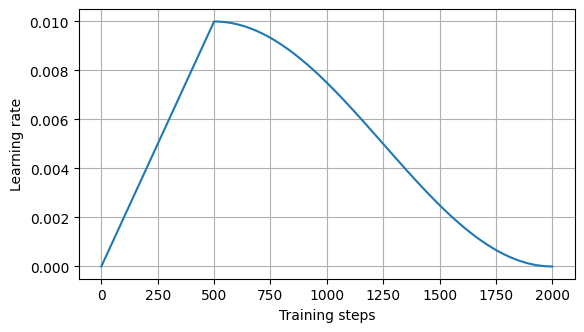

In [36]:
# DO NOT REMOVE OR MODIFY THIS CELL

# import create_learning_rate_fn from lnn_training.ipynb
from ipynb.fs.full.lnn_training import create_learning_rate_fn

_num_epochs = 20
_warmup_epochs = 5
_base_lr = 1e-2
_steps_per_epoch = 100

# call the factory function for the learning rate scheduler
_learning_rate_fn = create_learning_rate_fn(
    _num_epochs, _steps_per_epoch, _base_lr, _warmup_epochs
)

# evaluate the learning rate at each step
_steps = jnp.arange(0, _num_epochs * _steps_per_epoch)
_lrs = vmap(_learning_rate_fn, 0, 0)(_steps)

# plot the learning rate vs. training steps
_fig = plt.figure(figsize=(6.4, 3.5))
plt.plot(_steps, _lrs)
plt.xlabel("Training steps")
plt.ylabel("Learning rate")
plt.grid(True)
plt.show()


## Initializing the train states (1p)

Next in `initialize_train_states`, we initialize the neural network weights, the optimizer and save both in the Flax `TrainState` object:

1. For initializing the neural network weights, you can call the `init` method of the neural network object and as arguments provide a PRNG key and dummy inputs.

2. As an optimizer, we use the _AdamW_ optimizer, which is an Adam optimizer with weight decay. Remember to pass your custom `learning_rate_fn` to the `optax.adamw` method.

In [37]:
# DO NOT REMOVE OR MODIFY THIS CELL

# import initialize_train_states from lnn_training.ipynb
from ipynb.fs.full.lnn_training import initialize_train_states

_states = initialize_train_states(_rng, _learning_rate_fn)

print("MassMatrixNN TrainState:\n", _states["MassMatrixNN"])
print("PotentialEnergyNN TrainState:\n", _states["PotentialEnergyNN"])

MassMatrixNN TrainState:
 TrainState(step=0, apply_fn=<bound method Module.apply of MassMatrixNN(
    # attributes
    num_hidden = 32
)>, params=FrozenDict({
    params: {
        Dense_0: {
            kernel: Array([[-2.1150216e-01,  1.6974880e-01, -8.4307170e-01,  1.0659841e+00,
                    -1.2369871e+00,  2.9695395e-01,  5.0955212e-01, -3.2891321e-01,
                    -7.5929987e-01, -1.8039128e-01, -3.2328340e-01,  1.2963327e+00,
                    -8.8486981e-01,  4.2522004e-01,  5.5266041e-01,  5.5537093e-01,
                    -7.6041162e-01, -6.7844170e-01, -8.0852640e-01, -2.8492841e-01,
                    -1.3026830e+00,  8.8865489e-01, -1.0157790e+00,  5.2750391e-01,
                     4.4558275e-01,  1.9645461e-01,  1.1598716e+00, -7.1294212e-01,
                     1.7304517e-01, -6.1668479e-01, -9.1217047e-01, -8.5601822e-02],
                   [-9.8386055e-01, -1.0732154e+00,  1.0638116e-01, -1.1463668e+00,
                     2.2676565e-02, -1.2609

## Mean Squared Error (1p)

Please implement the `mse_loss_fn`, which shall compute the Mean Squared Error (MSE) between an array of predictions and an array of targets (i.e. labels).

In [38]:
# DO NOT REMOVE OR MODIFY THIS CELL

# import mse_loss_fn from lnn_training.ipynb
from ipynb.fs.full.lnn_training import mse_loss_fn

_rng1, _rng2 = random.split(_rng)

_pred = random.randint(_rng1, shape=(4, 6), minval=0, maxval=10)
_target = random.randint(_rng2, shape=(4, 6), minval=0, maxval=10)
print("Prediction:\n", _pred)
print("Target:\n", _target)

_mse = mse_loss_fn(_pred, _target)
print("MSE:", _mse)

# check that all dimensions have been reduced
assert _mse.shape == ()


Prediction:
 [[5 3 8 7 4 1]
 [8 2 3 9 6 7]
 [0 4 3 4 0 3]
 [9 0 7 2 0 6]]
Target:
 [[0 2 5 0 7 7]
 [5 2 9 5 8 6]
 [7 3 4 6 8 2]
 [6 5 9 0 9 1]]
MSE: 19.291666666666664


## Vectorization of the discrete-time forward dynamics (0.5p)

For training the neural network, we need to predict the link angles and the angular velocities at the next timestep for a **batch** of data. Although the function `discrete_forward_dynamics` in the `lnn.ipynb` notebook is only formulated for a single datapoint, we can use `jax.vmap` for vectorization. Please implement the `discrete_forward_dynamics_vmapped`, which shall have the following signature:

```python
th_next_pred_ss, th_d_next_pred_ss, th_dd_ss = discrete_forward_dynamics_vmapped(
    mass_matrix_nn_params,
    potential_energy_nn_params,
    dt_ss,
    th_curr_ss,
    th_d_curr_ss,
    tau_ss,
)
```
where `dt_ss` has the shape (N, ), `th_curr_ss` has the shape (N, 2), `th_d_curr_ss` has the shape (N, 2),
`tau_ss` has the shape (N, 2), `th_next_pred_ss` has the shape (N, 2), `th_d_next_pred_ss` has the shape (N, 2)
`th_dd_ss` has the shape (N, 2). N is the number of samples in the batch.

In [39]:
# DO NOT REMOVE OR MODIFY THIS CELL

# import discrete_forward_dynamics_vmapped from lnn_training.ipynb
from ipynb.fs.full.lnn_training import discrete_forward_dynamics_vmapped

_N = 10
_dt_ss = 1e-2 * jnp.ones((_N,))
_th_curr_ss = jnp.zeros((_N, 2))
_th_curr_ss = _th_curr_ss.at[:, 0].set(jnp.linspace(-jnp.pi, jnp.pi, _N))
_th_curr_ss = _th_curr_ss.at[:, 1].set(jnp.linspace(jnp.pi, -jnp.pi, _N))
_th_d_curr_ss = jnp.pi * jnp.ones((_N, 2))
_tau_ss = jnp.zeros((_N, 2))

# neural network params
_mass_matrix_nn_params = _states["MassMatrixNN"].params
_potential_energy_nn_params = _states["PotentialEnergyNN"].params

# print(_mass_matrix_nn_params)
# print(_mass_matrix_nn_params["params"])

_th_next_pred_ss, _th_d_next_pred_ss, _th_dd_ss = discrete_forward_dynamics_vmapped(
    _mass_matrix_nn_params,
    _potential_energy_nn_params,
    _dt_ss,
    _th_curr_ss,
    _th_d_curr_ss,
    _tau_ss,
)

print("Computed th_next_pred_ss:\n", _th_next_pred_ss)
print("Computed th_d_next_pred_ss:\n", _th_d_next_pred_ss)
print("Computed th_dd_ss:\n", _th_dd_ss)

assert _th_next_pred_ss.shape == (_N, 2)
assert _th_d_next_pred_ss.shape == (_N, 2)
assert _th_dd_ss.shape == (_N, 2)


Computed th_next_pred_ss:
 [[-3.02858754  3.17146789]
 [-2.40941564  2.47464202]
 [-1.7118735   1.7765725 ]
 [-1.01434525  1.07850476]
 [-0.31692035  0.38044371]
 [ 0.38016086 -0.31760223]
 [ 1.07625927 -1.01562098]
 [ 1.77002513 -1.71361032]
 [ 2.45817811 -2.41155773]
 [ 3.25459777 -3.11171742]]
Computed th_d_next_pred_ss:
 [[18.55641895  2.84815984]
 [ 3.6637889   3.09487473]
 [ 3.54668029  3.10725049]
 [ 3.42659626  3.11999732]
 [ 3.28554863  3.13410547]
 [ 3.07519202  3.15128778]
 [ 2.66643239  3.17403003]
 [ 1.78491341  3.2028729 ]
 [-0.23936444  3.2404983 ]
 [18.55641895  2.84815984]]
Computed th_dd_ss:
 [[ 1.81400150e+03 -3.37911859e+01]
 [ 5.33200952e+01 -4.74739741e+00]
 [ 4.13699135e+01 -3.49176697e+00]
 [ 2.91806991e+01 -2.20368732e+00]
 [ 1.49826579e+01 -7.86562171e-01]
 [-5.97220379e+00  9.22601366e-01]
 [-4.62007418e+01  3.15079928e+00]
 [-1.31753932e+02  5.92121723e+00]
 [-3.25018829e+02  9.44397391e+00]
 [ 1.81400150e+03 -3.37911859e+01]]


## Training and evaluation

Implement the execution of one training and evaluation step (i.e. processing of one minibatch) into the `train_step` and `eval_step` functions respectively. The `train_epoch` and the `eval_model` functions are already complete, but it is still worth for you to investigate their purpose and functionality. 

Below, we give you an overview of the necessary steps involved in one training epoch:

- We first randomly shuffle the order of the samples in the training set. Then, we divide the training set into many minibatches (all done in `train_epoch`).

- For each batch, we send the inputs through the LNN and evaluate the outputs of the LNN againts the labels for that batch (done in `train_step`).

- The MSE loss function called in `loss_fn` will provide us with a scalar loss metric of how well the LNN prediction matches with the target.

- In the `train_step`, we trace the gradients of the loss with respect to the neural network parameters backwards through the LNN.

- Then (again in `train_step`), `AdamW` will optimize the parameters of both neural networks using the computed gradients and considering the current learning rate. The current learning rate is provided by the learning rate scheduler, which is evaluated at the current step index (`TrainState.step`).

- Finally, an epoch is considered to be completed, when all samples of the training set have been processed **exactly** once.

**Hint:** to access both the loss and the gradient of the loss with respect to the network parameters, apply the `jax.value_and_grad` on the `loss_fn`. 

## Training loop: putting everything together

Please implement the full training loop into the function `run_lnn_training` in the `lnn_training.ipynb` notebook. 

In this training loop, we will repeat `train_epoch` multiple times (i.e. repeat the neural network parameter optimization for multiple epochs). For each epoch, we run `train_epoch` with a newly (randomly) shuffled training set, evaluate the freshly optimized neural network parameters on the validation set and save all data as a history, such that we can later track the training progress and identify the epoch with the lowest loss on the validation set.


You will need to implement the following items in `run_lnn_training`: first, you need to initialize the learning rate scheduler. Then, for each epoch of the training loop, you should:

1. Split the PRNG key for shuffling the training set for the current epoch.

2. Call the `train_epoch` function, which will return the training loss, some metrics on the training set and the freshly optimized training states containing the neural network parameters.

3. Call the `eval_model` function, which will return the validation loss and the validation metrics for the current training state.

## Executing the training loop

Now, you can ahead and run the training. We already provide you with a base set of hyperparameters, which in combination with a correct implementation and a suitable dataset should lead to decent performance. However, you are free to tune the hyperparameters yourself further to improve performance.

As the training could / should take longer, we advise you to take a ☕ break or to start already with one of the other tasks in the meantime.

In [40]:
# training hyperparameters
# these default values should already be working decently
# if you want to improve performance further, you can try fine-tuning these hyperparameters

# how many epochs to train for
num_epochs = 250
# base learning rate after warmup. Then, cosine decay will decrease the learning rate again
base_lr = 7e-4
# the learning rate will be linearly increase for `warmup_epochs` before reaching the `base_lr`
warmup_epochs = 10
# number of datapoints in one batch
batch_size = 250
# regularization / penalty on the magnitude of the NN weights
weight_decay = 0e0

In [41]:
# import run_lnn_training from lnn_training.ipynb
from ipynb.fs.full.lnn_training import run_lnn_training

# initialize the PRNG key at seed=0
rng = None
# YOUR CODE HERE
# raise NotImplementedError()
rng = jax.random.PRNGKey(seed=0)

# split of PRNG keys
# the 1st is used for training,
# the 2nd to split the dataset
# YOUR CODE HERE
# raise NotImplementedError()
dataset_split_rng, key2 = jax.random.split(rng, num=2)

# load the dataset
train_ds, val_ds = load_datasets(
    Path("datasets") / "dataset_double_pendulum_dynamics.npz",
    dataset_split_rng,
)

if not AUTOGRADING:
    # run the training calling `run_lnn_training`
    val_loss_history = []
    train_metrics_history = []
    val_metrics_history = []
    states_history = []
    # YOUR CODE HERE
    # raise NotImplementedError()

    val_loss_history, train_metrics_history, val_metrics_history, states_history = run_lnn_training(key2, train_ds, val_ds, num_epochs, 
                                                                                    batch_size, base_lr, warmup_epochs, weight_decay,True)




Training the Lagrangian neural network for 250 epochs...


  0%|          | 0/250 [00:00<?, ?it/s]

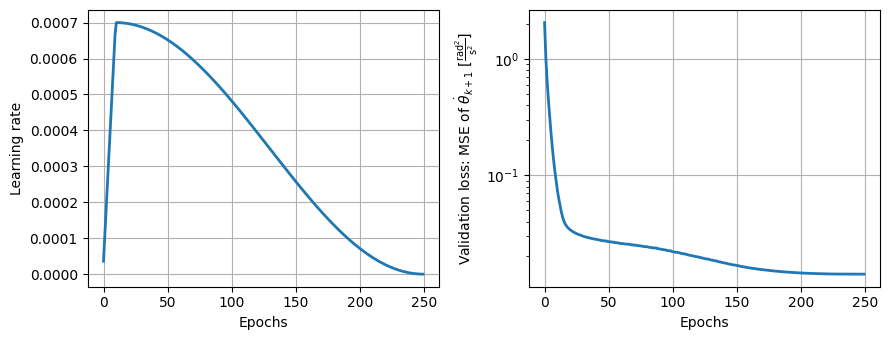

In [42]:
# visualization of the validation loss vs. epochs
if not AUTOGRADING:
    plot_lnn_training_convergence(
        val_loss_history,
        train_metrics_history,
        val_metrics_history,
        show=True,
        filepath=str(outputs_dir / "task_2c-3_lnn_training_convergence.pdf"),
    )

After the training loop is complete, we evaluate the performance of the neural network. It is important to emphasize that the best performance on the validation set is not necessarily always achieved during the last epoch of the training (e.g. overfitting, noise etc.). Therefore, we track the validation losses throughout the entire training, which allows us to identify the best epoch. 

In [43]:
if not AUTOGRADING:
    # extract the best epoch with the lowest validation loss
    best_epoch = 0
    # YOUR CODE HERE
    # raise NotImplementedError()
    # print(val_loss_history.shape)
    best_epoch = val_loss_history.argmin()
    # print(best_epoch)

    best_val_loss = val_loss_history[best_epoch]
    best_val_metrics = val_metrics_history[best_epoch]
    best_states = states_history[best_epoch]

    print(
        "Found lowest validation loss of",
        best_val_loss,
        "at epoch",
        best_epoch,
        "with metrics\n",
        best_val_metrics,
    )

Found lowest validation loss of 0.014097891893946312 at epoch 249 with metrics
 {'loss': 0.014097891893946312, 'rmse_th_d_next': 0.11873454381074748, 'rmse_th_next': 0.000593535533917316}


Now, we save the neural network parameters, which are stored in the variable `best_states`, to the path `statedicts/task_2c_lagrangian_nn_params.pkl`.

In [44]:
if not AUTOGRADING:
    # folder where to save neural network parameters
    statedict_dir = Path("statedicts")
    statedict_dir.mkdir(exist_ok=True, parents=True)

    # Save the neural network parameters
    with open(str(statedict_dir / "task_2c_lagrangian_nn_params.pkl"), "wb") as f:
        nn_params = {
            "MassMatrixNN": best_states["MassMatrixNN"].params,
            "PotentialEnergyNN": best_states["PotentialEnergyNN"].params,
        }
        dill.dump(nn_params, f)

## Visualizing the prediction performance

We predict with the trained LNN the discrete-time state transitions on the validation set and visualize the result in a polar plot with the link angular velocity $\dot{\theta}$ on the radial axis and the color visualizing the absolute value of the link angular acceleration prediction error $| \hat{\ddot{\theta}} - \ddot{\theta} |$.

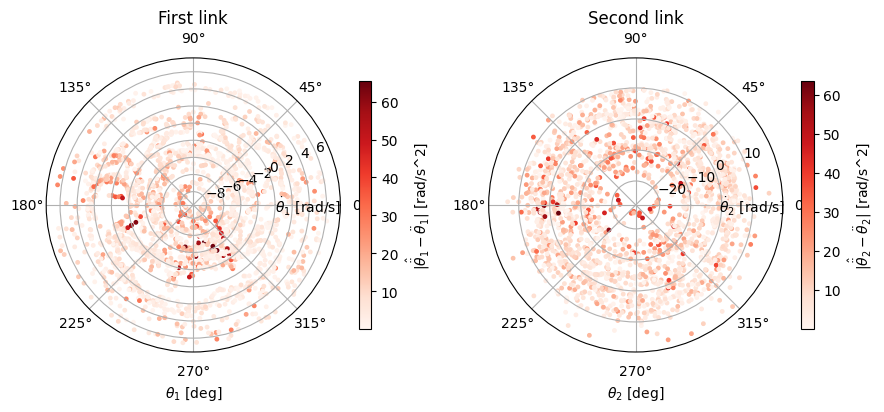

In [45]:
if not AUTOGRADING:
    # plot the prediction error of the best model
    # Compute the estimated link angles and velocities
    th_next_pred, th_d_next_pred, th_dd_pred = discrete_forward_dynamics_vmapped(
        best_states["MassMatrixNN"].params,
        best_states["PotentialEnergyNN"].params,
        val_ds["dt_ss"],
        val_ds["th_curr_ss"],
        val_ds["th_d_curr_ss"],
        val_ds["tau_ss"],
    )
    preds = {"th_next_ss": th_next_pred, "th_d_next_ss": th_d_next_pred}

    # plot the predictions
    plot_link_angular_acceleration_prediction_error(
        val_ds,
        preds,
        filepath=str(
            outputs_dir / "task_2c-3_link_angular_accelerations_prediction_error.pdf"
        ),
    )